## PGM Project

### Traffic

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel
from MAGMA import MAGMA
from trainer_gp_magma import Trainer_GP_MAGMA

### Data

In [2]:
DATA_PATH = "../datasets/Traffic/"
#DATA_PATH = "datasets/Traffic/"
traffic_train = np.array(pd.read_table(DATA_PATH + "TRAFFIC_TRAIN.tsv"))
traffic_test = np.array(pd.read_table(DATA_PATH + "TRAFFIC_TEST.tsv"))
traffic_train.shape, traffic_test.shape

((467, 192), (467, 192))

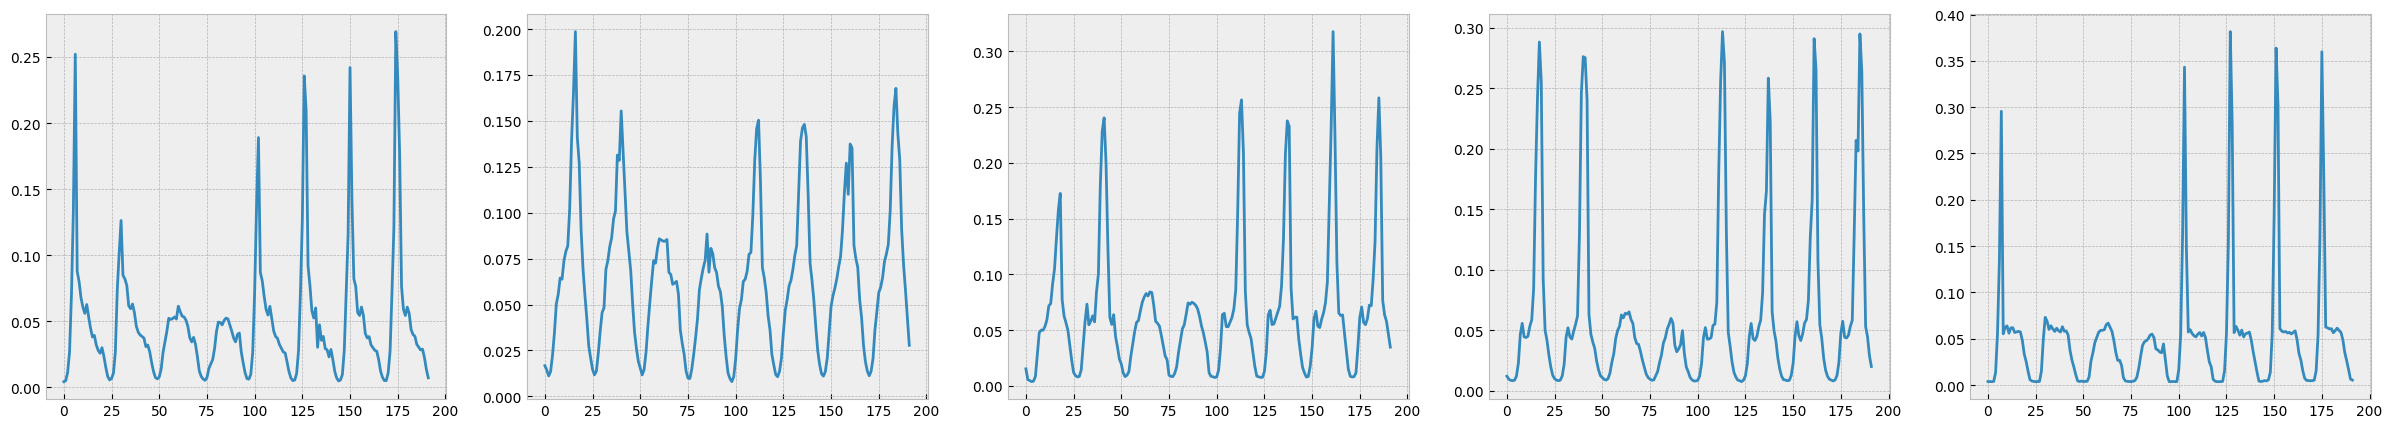

In [3]:
plt.figure(figsize=(30, 5))
for i, idx in enumerate(np.random.randint(len(traffic_train), size=5), 1):
    plt.subplot(1, 5, i)
    plt.plot(traffic_train[idx])
plt.show()

### Common grid : 60% observed, 40% unobserved

In [4]:
T = np.arange(0, 192)
N = 115
common_T = T[:N]
T_p = T[N:]

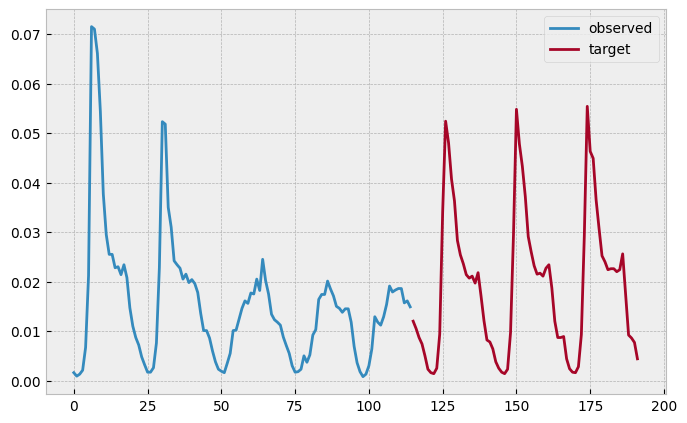

In [5]:
x = traffic_train[0]
x_obs = x[:N]
x_p = x[N:]
plt.figure(figsize=(8, 5))
plt.plot(common_T, x_obs, label="observed")
plt.plot(T_p, x_p, label='target')
plt.legend()
plt.show()

#### M = 5 

In [9]:
Y = traffic_train[:5, :N]
Y.shape

(5, 115)

##### Common HP

In [10]:
trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.array([np.exp(1), np.exp(1)]),
    Theta=np.array([np.exp(1), np.exp(1)]),
    Sigma=0.4,
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
trainer.train_models(max_iterations=20, eps=1e-2)

MAGMA Training: 100%|██████████| 20/20 [20:50<00:00, 62.51s/it]


###### Evaluation on train set

In [12]:
traffic_train_obs = traffic_train[:, :N]
traffic_train_p = traffic_train[:, N:]
traffic_train_obs.shape, traffic_train_p.shape

((467, 115), (467, 77))

In [13]:
mean_true_p = traffic_train_p.mean(axis=0)
mean_true_p.shape

(77,)

In [14]:
T_obss = np.tile(common_T, (len(traffic_train_p), 1))
T_ps = np.tile(T_p, (len(traffic_train_p), 1))
mean_true_ps = np.tile(mean_true_p, (len(traffic_train_p), 1))
T_obss.shape, T_ps.shape, mean_true_ps.shape

((467, 115), (467, 77), (467, 77))

In [15]:
all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)

Evaluation: 100%|██████████| 467/467 [1:07:51<00:00,  8.72s/it]


In [16]:
all_res = np.array(all_res)
all_res.shape

(467, 2)

In [17]:
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")

Magma : 0.006005114210606226 (0.00027684357859100256)
GPs : 0.006009125553193644 (3.642919299551295e-17)


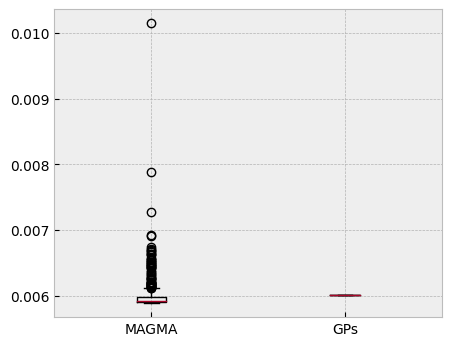

In [18]:
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

Evaluation: 100%|██████████| 467/467 [1:05:03<00:00,  8.36s/it]

Magma : 0.008687148524217826 (0.005005567994973581)
GPs : 0.00872106984924265 (0.0049626485420119)


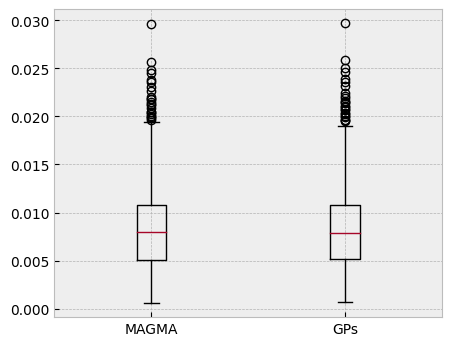

In [19]:
all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

##### Evaluation on test set

In [20]:
traffic_test_obs = traffic_test[:, :N]
traffic_test_p = traffic_test[:, N:]
traffic_test_obs.shape, traffic_test_p.shape

((467, 115), (467, 77))

In [21]:
mean_true_p = traffic_test_p.mean(axis=0)
mean_true_p.shape

(77,)

In [22]:
T_obss = np.tile(common_T, (len(traffic_test_p), 1))
T_ps = np.tile(T_p, (len(traffic_test_p), 1))
mean_true_ps = np.tile(mean_true_p, (len(traffic_test_p), 1))
T_obss.shape, T_ps.shape, mean_true_ps.shape

((467, 115), (467, 77), (467, 77))

Evaluation: 100%|██████████| 467/467 [1:05:07<00:00,  8.37s/it]

Magma : 0.005958137201311001 (0.00032623665690785535)
GPs : 0.0059385426347677945 (3.2959746043559335e-17)


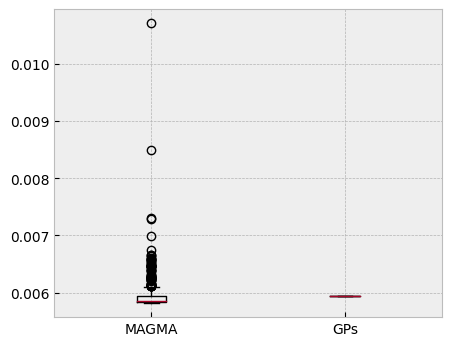

In [23]:
all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_test_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

Evaluation: 100%|██████████| 467/467 [1:04:50<00:00,  8.33s/it]

Magma : 0.008701406399784641 (0.004855209581732181)
GPs : 0.008707305055801341 (0.004777588961893956)


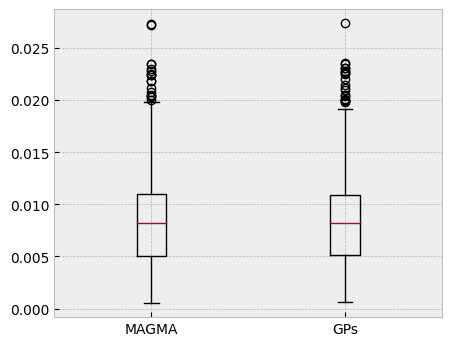

In [24]:
all_res = trainer.evaluate_models_all(traffic_test_p, T_ps, T_obss, traffic_test_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

#### Different HP

In [25]:
trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.exp(1)*np.ones(2),
    Theta=np.exp(1)*np.ones((5, 2)),
    Sigma=0.4*np.ones(5),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [26]:
trainer.train_models(max_iterations=20, eps=1e-2)

MAGMA Training: 100%|██████████| 20/20 [24:59<00:00, 74.99s/it]


In [27]:
mean_true_p = traffic_train_p.mean(axis=0)
T_obss = np.tile(common_T, (len(traffic_train_p), 1))
T_ps = np.tile(T_p, (len(traffic_train_p), 1))
mean_true_ps = np.tile(mean_true_p, (len(traffic_train_p), 1))
T_obss.shape, T_ps.shape, mean_true_ps.shape

((467, 115), (467, 77), (467, 77))

Evaluation: 100%|██████████| 467/467 [3:47:49<00:00, 29.27s/it]  

Magma : 0.0059881484757203585 (0.00017754569595525025)
GPs : 0.006009125553193644 (3.642919299551295e-17)


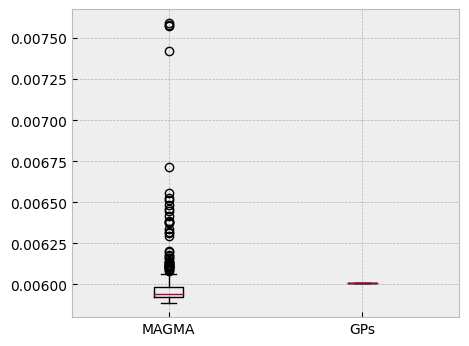

In [28]:
all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

Evaluation: 100%|██████████| 467/467 [3:49:14<00:00, 29.45s/it]  

Magma : 0.008664579721817126 (0.004997153066727936)
GPs : 0.00872106984924265 (0.0049626485420119)


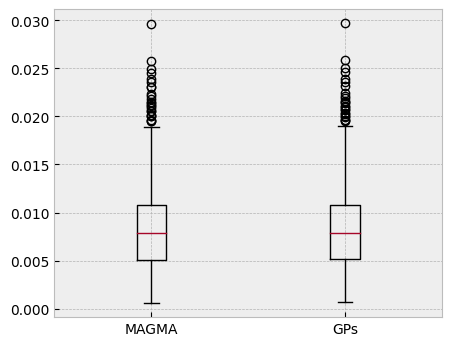

In [29]:
all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

In [30]:
Y_obs = traffic_train_obs[0]
Y_p = traffic_train_p[0]
magma_pred, gps_preds = trainer.predict_models(T_p, common_T, Y_obs)

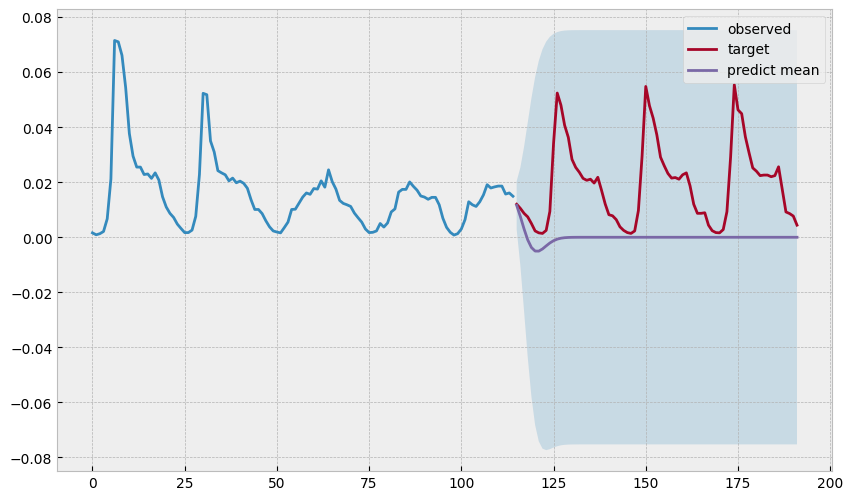

In [31]:
mean, Cov = magma_pred
std_dev = np.sqrt(np.diag(Cov))
plt.figure(figsize=(10, 6))
plt.plot(common_T, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target')
plt.plot(T_p, mean, label='predict mean')
plt.fill_between(T_p, mean - std_dev, mean + std_dev, alpha=0.2)
plt.legend()
plt.show()

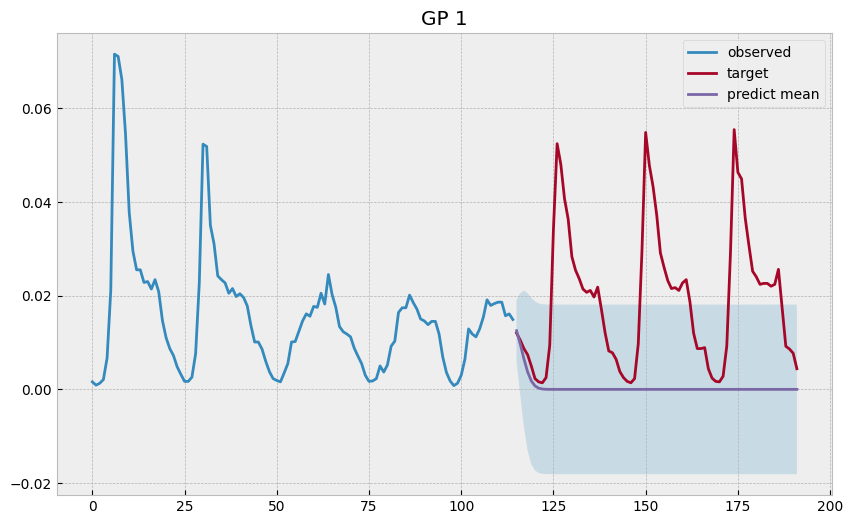

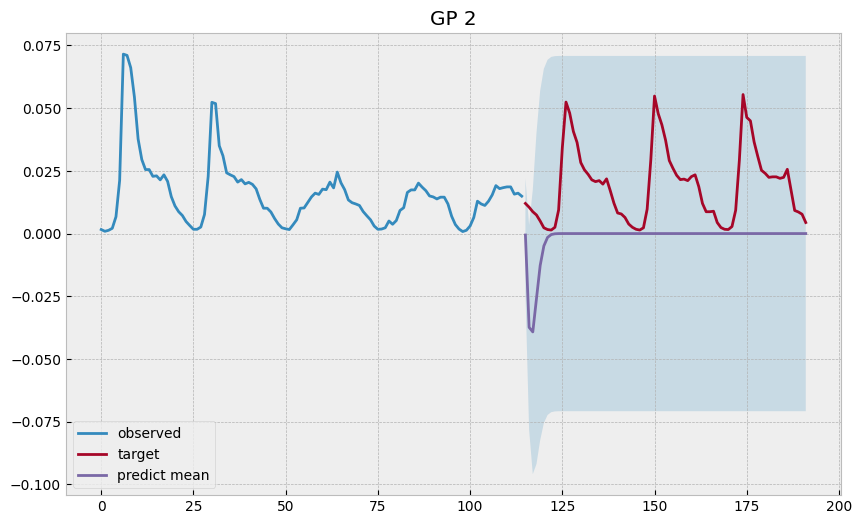

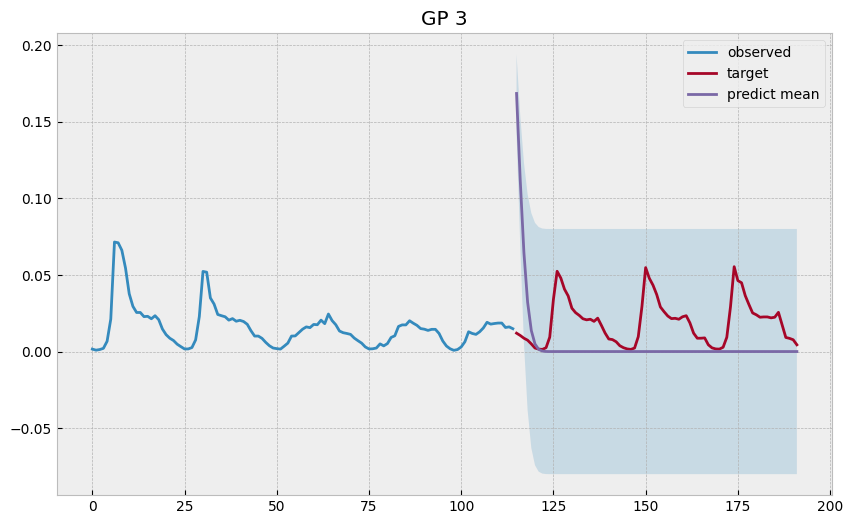

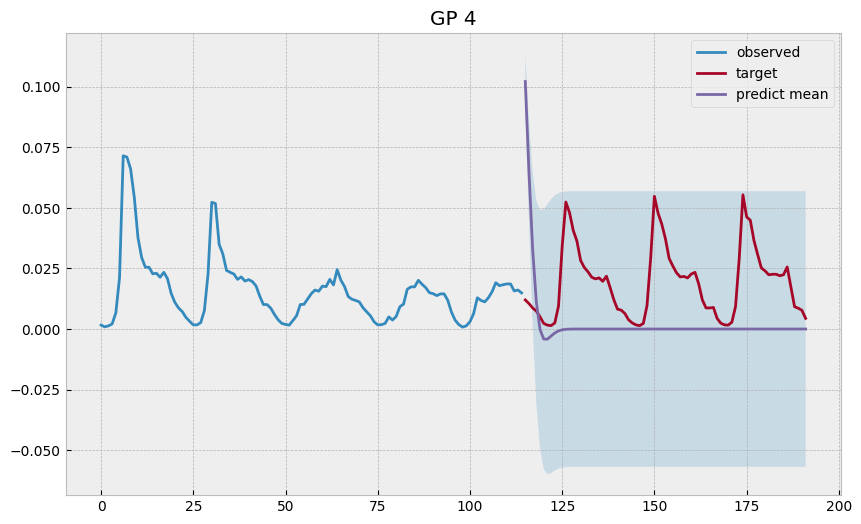

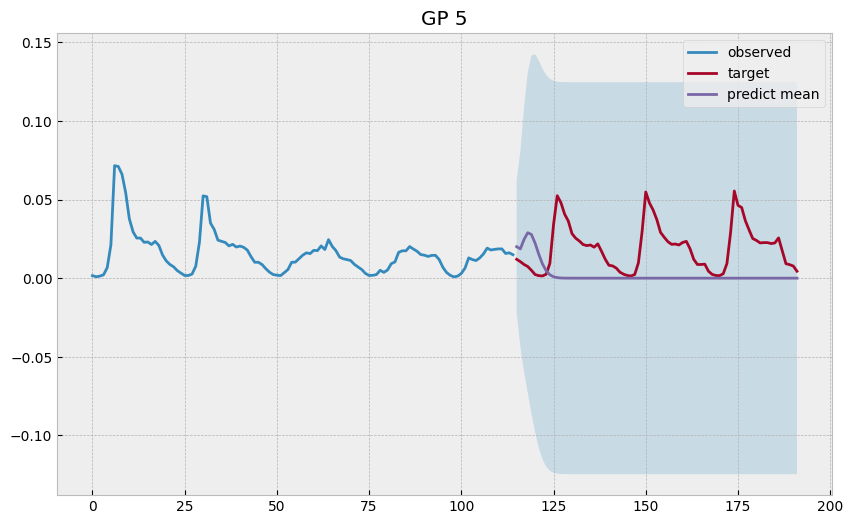

In [32]:
for i in range(len(gps_preds)):
    mean, Cov = gps_preds[i]
    std_dev = np.sqrt(np.diag(Cov))
    plt.figure(figsize=(10, 6))
    plt.plot(common_T, Y_obs, label="observed")
    plt.plot(T_p, Y_p, label='target')
    plt.plot(T_p, mean, label='predict mean')
    plt.fill_between(T_p, mean - std_dev, mean + std_dev, alpha=0.2)
    plt.title(f"GP {i + 1}")
    plt.legend()
    plt.show()

#### M = 10

In [33]:
Y = traffic_train[:10, :N]
Y.shape

(10, 115)

##### Common HP

In [34]:
trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.array([np.exp(1), np.exp(1)]),
    Theta=np.array([np.exp(1), np.exp(1)]),
    Sigma=0.4,
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)
trainer.train_models(max_iterations=20, eps=1e-2)

all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

MAGMA Training:   5%|▌         | 1/20 [05:38<1:47:06, 338.23s/it]

##### Different HP

In [ ]:
trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.exp(1)*np.ones(2),
    Theta=np.exp(1)*np.ones((10, 2)),
    Sigma=0.4*np.ones(10),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

trainer.train_models(max_iterations=20, eps=1e-2)

all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

#### M = 20

In [ ]:
Y = traffic_train[:20, :N]


trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.array([np.exp(1), np.exp(1)]),
    Theta=np.array([np.exp(1), np.exp(1)]),
    Sigma=0.4,
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)
trainer.train_models(max_iterations=20, eps=1e-2)

all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()


trainer = Trainer_GP_MAGMA()
trainer.init_models(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(N),
    m0_function=lambda x: np.zeros_like(x),
    theta0=np.exp(1)*np.ones(2),
    Theta=np.exp(1)*np.ones((20, 2)),
    Sigma=0.4*np.ones(20),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=False,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

trainer.train_models(max_iterations=20, eps=1e-2)

all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
all_res = np.array(all_res)
magma_mean, gp_mean = np.mean(all_res, axis=0)
magma_std, gp_std = np.std(all_res, axis=0)
print(f"Magma : {magma_mean} ({magma_std})")
print(f"GPs : {gp_mean} ({gp_std})")
labels = ["MAGMA", "GPs"]
plt.figure(figsize=(5, 4))
plt.boxplot(all_res, labels=labels)
plt.show()

### Common grid : 80% observed 20% unobserved

In [ ]:
T = np.arange(0, 140)
N = 153
common_T = T[:N]
T_p = T[N:]


for M in [5, 10, 20]:
    print()
    print(f"M = {M}")
    print("="*100)

    Y = traffic_train[:M, :N]

    print()
    print("Common HP")
    trainer = Trainer_GP_MAGMA()
    trainer.init_models(
        T=T,
        Y=Y,
        common_T=common_T,
        m0=np.zeros(N),
        m0_function=lambda x: np.zeros_like(x),
        theta0=np.array([np.exp(1), np.exp(1)]),
        Theta=np.array([np.exp(1), np.exp(1)]),
        Sigma=0.4,
        common_hp_flag=True,
        common_grid_flag=True,
        save_history_flag=False,
        scipy_optimize_display=False,
        kernel_k=ExponentiatedQuadraticKernel,
        kernel_c=ExponentiatedQuadraticKernel,
    )
    trainer.train_models(max_iterations=20, eps=1e-2)

    all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
    all_res = np.array(all_res)
    magma_mean, gp_mean = np.mean(all_res, axis=0)
    magma_std, gp_std = np.std(all_res, axis=0)
    print(f"Magma : {magma_mean} ({magma_std})")
    print(f"GPs : {gp_mean} ({gp_std})")
    labels = ["MAGMA", "GPs"]
    plt.figure(figsize=(5, 4))
    plt.boxplot(all_res, labels=labels)
    plt.show()

    all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
    all_res = np.array(all_res)
    magma_mean, gp_mean = np.mean(all_res, axis=0)
    magma_std, gp_std = np.std(all_res, axis=0)
    print(f"Magma : {magma_mean} ({magma_std})")
    print(f"GPs : {gp_mean} ({gp_std})")
    labels = ["MAGMA", "GPs"]
    plt.figure(figsize=(5, 4))
    plt.boxplot(all_res, labels=labels)
    plt.show()

    print()
    print("Different HP")

    trainer = Trainer_GP_MAGMA()
    trainer.init_models(
        T=T,
        Y=Y,
        common_T=common_T,
        m0=np.zeros(N),
        m0_function=lambda x: np.zeros_like(x),
        theta0=np.exp(1)*np.ones(2),
        Theta=np.exp(1)*np.ones((M, 2)),
        Sigma=0.4*np.ones(M),
        common_hp_flag=False,
        common_grid_flag=True,
        save_history_flag=False,
        scipy_optimize_display=False,
        kernel_k=ExponentiatedQuadraticKernel,
        kernel_c=ExponentiatedQuadraticKernel,
    )
    trainer.train_models(max_iterations=20, eps=1e-2)

    all_res = trainer.evaluate_models_all(mean_true_ps, T_ps, T_obss, traffic_train_obs)
    all_res = np.array(all_res)
    magma_mean, gp_mean = np.mean(all_res, axis=0)
    magma_std, gp_std = np.std(all_res, axis=0)
    print(f"Magma : {magma_mean} ({magma_std})")
    print(f"GPs : {gp_mean} ({gp_std})")
    labels = ["MAGMA", "GPs"]
    plt.figure(figsize=(5, 4))
    plt.boxplot(all_res, labels=labels)
    plt.show()

    all_res = trainer.evaluate_models_all(traffic_train_p, T_ps, T_obss, traffic_train_obs)
    all_res = np.array(all_res)
    magma_mean, gp_mean = np.mean(all_res, axis=0)
    magma_std, gp_std = np.std(all_res, axis=0)
    print(f"Magma : {magma_mean} ({magma_std})")
    print(f"GPs : {gp_mean} ({gp_std})")
    labels = ["MAGMA", "GPs"]
    plt.figure(figsize=(5, 4))
    plt.boxplot(all_res, labels=labels)
    plt.show()